In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

C:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_env\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

C:\Users\rgoix\AppData\Local\Continuum\anaconda3\envs\quetzal_env\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
distribution = stepmodel.read_zip(training_folder + r'model/{scen}/distribution.zip'.format(scen=scenario))
sm = stepmodel.read_zip(training_folder + r'model/base/walk_model.zip'.format(scen=scenario))

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.86it/s]


In [5]:
sm.volumes = distribution.volumes

# rail submodel

In [6]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])] 

# strategy finder

In [7]:
rail.links['trip_id'] = rail.links['trip_id'].apply(lambda i: i.replace(':', '_').replace(' ', '_'))
rail.links= rail.links.loc[rail.links['a'] != rail.links['b']]

In [8]:
rail.nodes.index.name='index'
rail.step_strategy_finder()

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [02:26<00:00,  1.33s/it]


# assignment

In [10]:
rail.nodes.index.name='index'
rail.step_strategy_assignment('pt_captive')

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.57it/s]


In [12]:
import os
from graphviz import Source
os.environ["PATH"] += os.pathsep + r'C:\Users\qchasserieau\dev\graphviz-2.38\release\bin/'
from IPython.core import display
import numpy as np
import networkx as nx

rail.links['trip_id'] = rail.links['trip_id'].apply(lambda i: i.replace(':', '_').replace(' ', '_'))

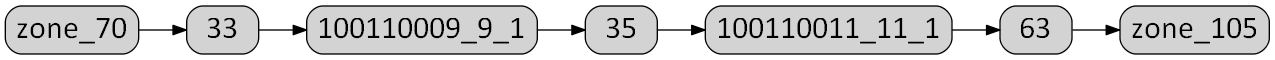

In [14]:
header = """
ratio = fill; 
node [style="filled,rounded" ,shape="record", fontname = "calibri", fontsize=24,];
edge[ fontname = "calibri", fontsize=24];
ranksep = "0.5";
rankdir="LR";
"""
origin, destination='zone_70',  'zone_105'
a = rail.get_aggregated_edges(origin, destination)
a['l'] = 'p=' + np.round(a['p'], 2).astype(str) #+ '\nh:' + a['h'].astype(str)
a.loc[a['p'] == 1, 'l'] = ''

odg = nx.DiGraph()
for e in a.to_dict(orient='records'):
    odg.add_edge(e['i'], e['j'], label=e['l'])
name='test'
dot_string = nx.nx_pydot.to_pydot(odg).to_string().replace('{', '{' + header)
src = Source(dot_string,format='png')
display.Image(filename=src.render(name))

In [15]:
self = rail
edges = self.optimal_strategy_edges[['i', 'j', 'f', 'c']].copy()
edges = edges.loc[self.optimal_strategy_sets.loc[destination]]
edges['ix'] = edges.index

# removing the edges that are non relevant (p<1e-6)
f_total = edges.groupby('i')[['f']].sum()
edges = pd.merge(edges, f_total, left_on='i', right_index=True, suffixes=['', '_total'])
edges['p'] = np.round(edges['f'] / edges['f_total'], 6)
edges = edges.loc[edges['p'] > 0]

In [16]:
#restriction to the origin
g = nx.DiGraph()
for e in edges.to_dict(orient='records'):
    g.add_edge(e['i'], e['j'])

paths = list(nx.all_simple_paths(g, source=origin, target=destination))
nodes = set.union(*[set(p) for p in paths])
ode = edges.loc[edges['i'].isin(nodes) & edges['j'].isin(nodes)]

In [17]:
rail.links.groupby(['a', 'b', 'trip_id']).first()

index  link_sequence  departure_time  arrival_time  \
a  b   trip_id                                                              
1  119 100110002_2_3    4294             23         28620.0       28740.0   
   183 100110001_1_0    4170              3         27600.0       27660.0   
   205 100110001_1_1    4200             16         28680.0       28740.0   
   266 100110006_6_2    4484              2         26880.0       26940.0   
   287 100110002_2_2    4250              3         27120.0       27240.0   
...                      ...            ...             ...           ...   
94 227 100110008_8_1    4667             25         33960.0       34020.0   
97 156 100110005_5_0    4418             14         28440.0       28560.0   
   69  100110005_5_1    4426              5         27600.0       27720.0   
99 44  100110011_11_1   4830              9         28620.0       28680.0   
   63  100110011_11_0   4815              5         28680.0       28740.0   

                        time  headway      pattern_id      route_id  \
a  b   trip_id                                                        
1  119 100110002_2_3   120.0    116.0   100110002:2_3   100110002:2   
   183 100110001_1_0    60.0     95.0   100110001:1_0   100110001:1   
   205 100110001_1_1    60.0     92.0   100110001:1_1   100110001:1   
   266 100110006_6_2    60.0    112.0   100110006:6_2   100110006:6   
   287 100110002_2_2   120.0    116.0   100110002:2_2   100110002:2   
...                      ...      ...             ...           ...   
94 227 100110008_8_1    60.0    138.0   100110008:8_1   100110008:8   
97 156 100110005_5_0   120.0    109.0   100110005:5_0   100110005:5   
   69  100110005_5_1   120.0    109.0   100110005:5_1   100110005:5   
99 44  100110011_11_1   60.0    106.0  100110011:11_1  100110011:11   
   63  100110011_11_0   60.0    109.0  100110011:11_0  100110011:11   

                      service_id  \
a  b   trip_id                     
1  119 100110002_2_3        8178   
   183 100110001_1_0        8178   
   205 100110001_1_1        8178   
   266 100110006_6_2        8178   
   287 100110002_2_2        8178   
...                          ...   
94 227 100110008_8_1        8178   
97 156 100110005_5_0        8178   
   69  100110005_5_1        8178   
99 44  100110011_11_1       8178   
   63  100110011_11_0       8178   

                                                         trip_headsign  ...  \
a  b   trip_id                                                          ...   
1  119 100110002_2_3   Porte Dauphine (Maréchal de Lattre de Tassigny)  ...   
   183 100110001_1_0                              Château de Vincennes  ...   
   205 100110001_1_1                         La Défense (Grande Arche)  ...   
   266 100110006_6_2                                            Nation  ...   
   287 100110002_2_2                                            Nation  ...   
...                                                                ...  ...   
94 227 100110008_8_1                                     Pointe du Lac  ...   
97 156 100110005_5_0                                    Place d'Italie  ...   
   69  100110005_5_1                             Bobigny-Pablo-Picasso  ...   
99 44  100110011_11_1                                 Mairie des Lilas  ...   
   63  100110011_11_0                                         Châtelet  ...   

                      route_color  route_text_color     road_a      road_b  \
a  b   trip_id                                                               
1  119 100110002_2_3       003CA6            ffffff   21292970    34816544   
   183 100110001_1_0       FFCD00            000000     368319   260928395   
   205 100110001_1_1       FFCD00            000000     368319    27286674   
   266 100110006_6_2       6ECA97            000000   21660924      368307   
   287 100110002_2_2       003CA6            ffffff   21292970   273415577   
...                           ...               ...   